## 1. 데이터 다운로드 

~/aiffel/lyricist/data/lyrics에 데이터가 있음

In [1]:
! mkdir -p ~/aiffel/lyricist/models
! ln -s ~/data ~/aiffel/lyricist/data

ln: failed to create symbolic link '/aiffel/aiffel/lyricist/data/data': Read-only file system


## 2. 데이터 읽어오기
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이  
 glob 를 활용하여 모든 txt 파일을 읽어온 후,  
 raw_corpus 리스트에 문장 단위로 저장

In [2]:
#준비한 파일 내용 확인
import os, re
import numpy as np
import tensorflow as tf
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []


##### 데이터 확인해보기

In [3]:
#몇개의 파일이 있지?
print(f'The number of lyrics : {len(txt_list)}')

The number of lyrics : 49


In [4]:
# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("문장 총 개수:", len(raw_corpus))
print("Examples:\n", raw_corpus[:30])

문장 총 개수: 187088
Examples:
 ['[Hook]', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face [Verse 1]', "Somethin' ain't right when we talkin'", "Somethin' ain't right when we talkin'", "Look like you hidin' your problems", 'Really you never was solid', 'No, you can\'t "son" me', "You won't never get to run me", 'Just when shit look out of reach', 'I reach back like one, three', 'Like one, three, yeah [Pre-Hook]', "That's when they smile in my face", 'Whole time they wanna take my place', 'Whole time they wanna take my place', 'Whole time they wanna take my place', 'Yeah, I know they wanna take my place', 'I can tell that love is fake', "I don't trust a word you say", 'How you wanna clique up after your mistakes?',

## 3. 데이터 정제

##### 1) 정제 함수 정의

In [22]:
#정제 함수 
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    #[] 부분은 훅이나 벌스같은 노래 부분 설명 단어라서 제외
    sentence = re.sub("\[.*\]*", " ", sentence)
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    #'아포스트로피도 축약, 소유격 표시등을 해주는 의미가 있어서 출력에 포함
    sentence = re.sub(r"[^a-z?.!,¿,']+", " ", sentence) 
    sentence = sentence.strip() 
    sentence = '<start> ' + sentence + ' <end>' 
    return sentence

# 정제 결과 확인
print(preprocess_sentence(raw_corpus[1]))
print(preprocess_sentence(raw_corpus[13]))

<start> i've been down so long , it look like up to me <end>
<start> no , you can't son me <end>


#### 2) 함수로 정제된 문장 모으기

In [6]:
# 정제된 문장들 모으기
corpus = []

for sentence in raw_corpus:
    # 아무것도 없는 문장 건너뛰기
    if len(sentence) == 0: continue
        #건너뛰는 문장이 있는지 모르겠음 :이 데이터에 없는 것 같지만 
        #모든 데이터를 보지 못했기 때문에 혹시모를 확률에 대한 대비
        
        #문장길이 15 넘어가면 건너뛰기
    if (sentence.count(' ')+1 > 15) : continue
    if sentence[-1] == ")": continue
    if sentence[-1] == "]": continue
        
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인
print(len(corpus))
corpus[:10]

159742


["<start> i've been down so long , it look like up to me <end>",
 '<start> they look up to me <end>',
 "<start> i got fake people showin' fake love to me <end>",
 '<start> straight up to my face , straight up to my face <end>',
 "<start> i've been down so long , it look like up to me <end>",
 '<start> they look up to me <end>',
 "<start> i got fake people showin' fake love to me <end>",
 "<start> somethin' ain't right when we talkin' <end>",
 "<start> somethin' ain't right when we talkin' <end>",
 "<start> look like you hidin' your problems <end>"]

#### 3) 토큰화

In [7]:
#15개 이상의 토큰을 가지면 제거 
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞추기-> 시퀀스 길이 맞추려고
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    #문장 길이 설정 해주기
    #total_data_text = list(tensor)
    #num_tokens = [len(tokens) for tokens in total_data_text]
    #max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    #maxlen = int(max_tokens)
    
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

#https://keras.io/ko/preprocessing/text/ : 토큰화 전처리

[[   2  145   99 ...   11    3    0]
 [   2   41  131 ...    0    0    0]
 [   2    6   34 ...    0    0    0]
 ...
 [   2   82  727 ...    0    0    0]
 [   2  213    3 ...    0    0    0]
 [   2    9 1409 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7efee197ead0>


In [8]:
#텐서 출력 해보기
print(tensor[:3])

#최대 15개까지만 토큰화된것 확인가능

[[   2  145   99   55   29  161    4   13  131   20   27   10   11    3
     0]
 [   2   41  131   27   10   11    3    0    0    0    0    0    0    0
     0]
 [   2    6   34  852  179 3086  852   36   10   11    3    0    0    0
     0]]


In [9]:
# tokenizer에 구축된 단어 사전의 인덱스 확인해보기

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a
10 : to


In [10]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성
src_input = tensor[:, :-1]  

# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 145  99  55  29 161   4  13 131  20  27  10  11   3]
[145  99  55  29 161   4  13 131  20  27  10  11   3   0]


## 4. 데이터셋 정의, 분리

##### 1) 데이터셋 정의

In [11]:
#데이터셋 객체 생성 -> 근데 학습할때 사용하지 않고, 그냥 분리한걸로만 했음
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256

steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

##### 2) 데이터셋 분리

In [24]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input, 
                                                    test_size = 0.2,
                                                    shuffle=True,
                                                    random_state=34)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

# 124960,14

Source Train: (127793, 14)
Target Train: (127793, 14)


## 5. 모델 생성, 학습

##### 1) 모델 정의

In [13]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

##### 2) 모델 생성

In [21]:
#하이퍼파라미터 : embedding_size, hidden_size
embedding_size = 512 #단어 하나당 특징=feature 수
hidden_size = 2048  #레이어의 노드수, 뱃사공 , 너무 많으면 산으로 간다
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 8.75830010e-05,  2.43609509e-04,  5.97184271e-06, ...,
          1.08231006e-05, -1.54720634e-04,  3.07694980e-04],
        [-2.66004154e-05,  2.85750371e-04, -4.33792047e-05, ...,
         -1.35130889e-04, -3.76703465e-05,  7.09144282e-04],
        [-2.54879487e-05,  3.05732479e-04,  5.51747871e-05, ...,
         -1.90342776e-04, -1.20728095e-04,  1.12892163e-03],
        ...,
        [-3.18992825e-04, -3.11982329e-03, -1.58103212e-04, ...,
          1.34156703e-03,  2.51775701e-03,  4.53226181e-04],
        [-3.26814567e-04, -3.50626651e-03, -6.05488640e-05, ...,
          1.43968046e-03,  2.81520188e-03,  2.76900973e-04],
        [-3.24832188e-04, -3.86408996e-03,  5.65959199e-05, ...,
          1.51914905e-03,  3.07173119e-03,  9.18245714e-05]],

       [[ 8.75830010e-05,  2.43609509e-04,  5.97184271e-06, ...,
          1.08231006e-05, -1.54720634e-04,  3.07694980e-04],
        [ 4.19021535e-06,  4.62391035e-04,  8

In [15]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6720560   
_________________________________________________________________
lstm (LSTM)                  multiple                  21372928  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 86,246,161
Trainable params: 86,246,161
Non-trainable params: 0
_________________________________________________________________


##### 3) 모델 학습

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

hist = model.fit(enc_train, 
          dec_train, 
          epochs=10,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)


Epoch 1/10
500/500 [==============================] - 493s 981ms/step - loss: 3.9416 - accuracy: 0.4466 - val_loss: 3.0726 - val_accuracy: 0.5056
Epoch 2/10
500/500 [==============================] - 490s 980ms/step - loss: 2.9551 - accuracy: 0.5131 - val_loss: 2.7977 - val_accuracy: 0.5307
Epoch 3/10
500/500 [==============================] - 491s 982ms/step - loss: 2.6016 - accuracy: 0.5418 - val_loss: 2.6131 - val_accuracy: 0.5519
Epoch 4/10
500/500 [==============================] - 892s 2s/step - loss: 2.2754 - accuracy: 0.5770 - val_loss: 2.4761 - val_accuracy: 0.5751
Epoch 5/10
500/500 [==============================] - 941s 2s/step - loss: 1.9673 - accuracy: 0.6193 - val_loss: 2.3759 - val_accuracy: 0.5961
Epoch 6/10
500/500 [==============================] - 944s 2s/step - loss: 1.6867 - accuracy: 0.6673 - val_loss: 2.3034 - val_accuracy: 0.6159
Epoch 7/10
500/500 [==============================] - 944s 2s/step - loss: 1.4467 - accuracy: 0.7140 - val_loss: 2.2636 - val_accurac

## 6. 시각화

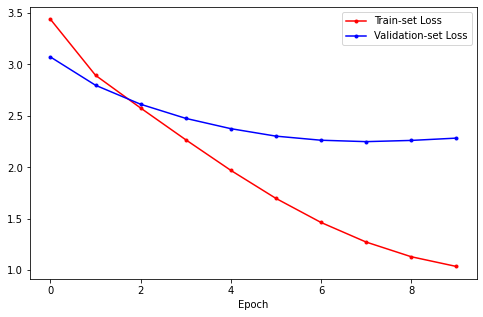

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(hist.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(hist.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 7. 평가 : 문장 생성

In [31]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [32]:
print(generate_text(model, tokenizer, init_sentence="<start> i love"))

<start> i love unexplained unexplained unexplained sniffing grandparents grandparents somewhat somewhat somewhat krunk fantasy fantasy fantasy apollonia jesus' snuck snuck 


In [33]:
keywords = ['love', 'my love', 'I','me' ,'you', 'she', 'he', 'hello', 'no', 'you must','am','not']
for start in keywords:
    print(generate_text(model, tokenizer, init_sentence= ' '.join(["<start>", start])))

<start> love showed wen wen swinger soulmate goddamn treat rubs fussing fussing fussing sendin fussing tooths tooths tooths ned tooths 
<start> my love symbol travel twilight twilight traces traces traces traces wedding wedding wedding twistelettes twistelettes delighted delighted delighted members 
<start> i nighttime others others others how're how're naire naire grab royal royal merrily merrily merrily merrily merrily around around 
<start> me 'fro 'fro dubs canada witnessed witnessed ej dick dick dick dick eatin eatin generations generations ? angry plea 
<start> you temper temper passengers passengers passengers answers sixty sixty sloppy royalty royalty royalty royalty unusual ridge ridge raindrops raindrops 
<start> she showed baskets thy thy symphony symphony co co quickly breasts breasts breasts radio's radio's radio's duh duh duh 
<start> he pacing purring purring speak speak speak speak marley marley frightening exaggeration exaggeration yellin' yellin' i'ma opinions opinion

## 8. 회고

### 💚누브릭 = 평가 지표
##### 1.텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?  
(정상적 텍스트 생성 모델)  
다양한 시도들에서..그래도 문장이 그럴듯하게 나왔었는데 ㅠㅠ  
현재 코드에서는.. 돌림노래 수준으로 라임을 맞춰서 나옴ㅋㅋㅋㅋ  
라임과 돌림노래 전문 작사가라면 제 사이버 작사가 친구가 으뜸...
사이버 계의 김이나 작사가,,

다른 코드들과 해당 코드가 뭐가 다른건지도 봐봐야겠음  
loss가 2.2로 안떨어지더라도 무난하게 나오는 편이였는데;;  
당황스럽...  
일단 제출 5분 전이라.. 그냥 제출하고  

무난하게 문장 나왔던거 다시 run돌려서  
다시 문장 생성해서  
첨부하기로...ㅠㅠㅠ  
도대체 앞전거랑 뭐가 다른데  
max_len = 20 해놓은것도 안된걸까..  
과적합인가?!

##### 2.특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?  
(데이터 전처리,구성과정이 체계적인가?)
>**1) 특수문자 제거**  
-> 노드에 제시된 전처리 후 소스데이터 개수 : 124960  
-> 내가 시도한 후 전처리 후 소스데이터 개수 : 127793  
비슷한 데이터 개수로 성공적이라고 판단 됨  
><br>
**2)아포스트로피 '**
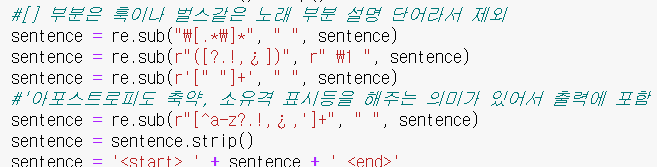
<br>
>정제 함수 정의하면서, 아포스트로피도 데이터에 포함시킴  
나는 모델 학습까지 다하고,  
문장 생성을 해보고 나서야 알게됨  
코드짤때 조금 더 다각화된 시각으로 기능을 만드는 것을 계속 연습해봐야함  
<br>
>**3)토크나이저 생성, 패딩처리**  
토큰화, 패딩 처리 완료  
패딩 처리하고난 후, 너무 긴 문장은 max_len=15로 최대 길이 15로 설정함  
노드에서 15라고 했는데,  
해당 부분에서 주석 달아놓은 것 처럼  
실제 데이터가 가지는 길이를 감안한 확장성 있는 코드가 더 좋다고 평가됨  
(해당 부분은 아래의 배운점에서 조금 더 언급)


##### 3.텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?  
(모델의 안정성)  
아니요... 또또 2.2 언저리 val_loss 값이 나옴  
노드에서 에포크 10번으로 지정해주어서  
에포크 값은 변경하지 못한채로 계속 학습을 진행했는데  
다시 val_loss가 낮아지는지  
추후에는 에포크 값을 늘려서 학습해보고 싶음  

**vla_loss 2.2 언저리 값이 나온 시도들**  
>1  
BATCH_SIZE = 256  
embedding_size = 256  
hidden_size = 2048  
epochs=10  
에포크 9번째 결과 :  2.30  
<br>
>2  
BATCh_SIZE = 128  
embedding_size = 512  
hidden_size = 2048  
batch_size=512,  
epochs=10,  
에포크 10번째 결과 : 2.2576  
> 그밖에 기록하지 않은 결과들...n*n차,, ㅠ


### 그래서 결국
😂만족스럽지는 않은 결과에 따른 대안으로 **양방향 LSTM 시도**

### 💚어려웠던 점 
##### 1. 하이퍼파라미터
**기준없이, 직관적으로 하이퍼 파라미터를 지정**하고  
학습시키는 과정이 너무 힘들었음  
직관을 가지고 찍으면서, 인사이트를 얻으면서 개선시켜야 하는데,  
모델 학습 시간 자체도 너무 오래걸렸기 때문에 힘들었음  
그런데 하이퍼 파라미터 최적화 내용으로 cs231n과 E-06 노드에서  
**랜덤 서치** 개념을 배움  
(랜덤 서치 개념은 아래의 추후 시도할 점에서 더 언급)  
<br>
##### 2. val_loss =2.2  
loss 값의 의미를 잘 모르겠음  
노드에서 제대로된 평가지표가 없기때문에  
직접 문장을 생성해봐야한다고 함  
2점대의 loss 값 모두 생성된 문장 성능에 대해서는  
크게 눈에 띄게 다른 점이 없었음  
그런데 val_loss =2.2 이하로 낮추기가 굉장히 어려웠음  
이렇게까지 loss에 집착해야하는가에 대한 의문이 듦  

### 💚 배운점 
##### 1. 하이퍼파라미터
loss 값을 낮춰가면서 각각의 하이퍼 파라미터에 대한 개념에 대해  
명확하게 이해할 수 있었던 학습 경험이었음  

##### 2. ResourceExhaustedError
run 중에 계속 이따금 해당오류가 남  
에러 내용에 대해 알아보니  
GPU 메모리 할당 오류라고 함  
해결방법으로 GPU 할당량을 줄이기 위해 batch_size를 줄이도록 함  
그러나 줄여도 계속 오류가 나서보니  
클라우드상 run 되고 있는 문서가 많기 때문인것 같음  
running 파일 목록에서 셧다운을 하니 모델이 돌아감 

##### 3. 양방향 LSTM
해당 부분에 대한 회고 부분은  
양방향 LSTM 파일에 있음  

##### 3. 데이터 셋으로 학습  
위에서는 생성해놓은 데이터 셋으로 학습시키지 않았음  
그래서 다른 학습에서는 데이터 셋으로 해서 학습시킴  

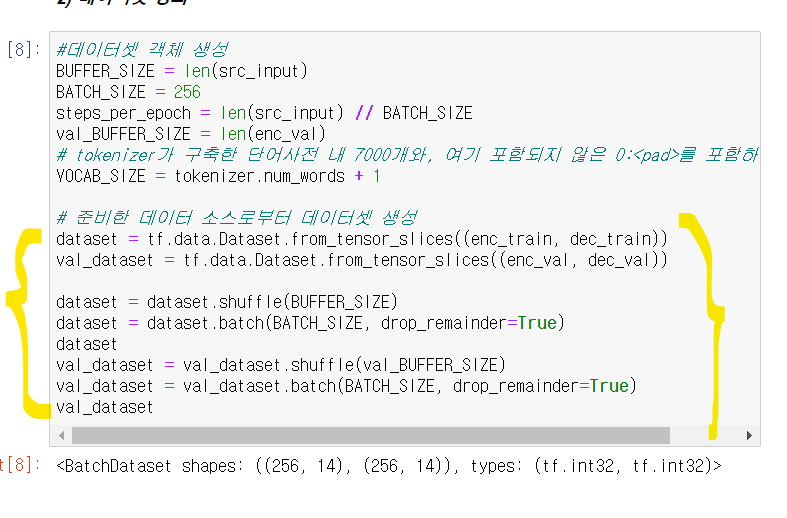

제출일의 오후 11:45분 경,  
수정한 파라미터로 다시 모델 학습중,,,  
BATCH_SIZE = 256  
embedding_size = 1400   
hidden_size = 2048   
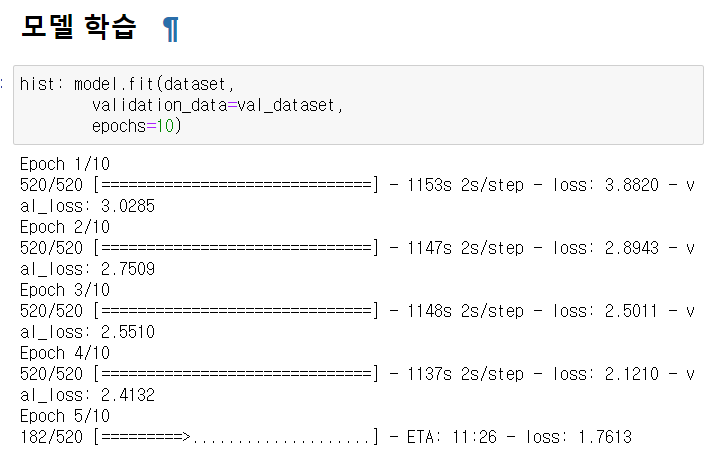

### 💚개선점 = 나중에 더 시도해보고 싶은 것
**하이퍼파라미터 최적화 =  Bayeisan Optimization**  
그리드 서치, 랜덤 서치 말고 다른 하이퍼 파라미터 최적화 방법   
하단 블로그에 내용 잘 정리되어 있음  
https://dacon.io/competitions/open/235698/talkboard/403915?page=1&dtype=recent  
랜덤 서치를 해당 모델에서 구현해보고 싶음 
우리 모델에서는 하이퍼 파라미터 최적화 방법 말고, 손수 지정해주고 있는게 맞음  
아래에 그리드 서치에 대한 코드화가 나오는데, 해당 부분 코드도 지금 코드에 없음  
https://huidea.tistory.com/32
